# Business Reporting System: A Data Analysis and Visualization Project
This project involves both a detailed data analysis in Jupyter Notebook and an interactive Tableau dashboard. The Tableau dashboard is designed to allow stakeholders to explore key metrics and trends, supporting data-driven decision-making.

## Key Objectives: 
- Analyze sales performance across different segments and countries.
- Identify key trends in pricing, costs, and profitability.
- Provide actionable recommendations based on data insights to support business decision-making.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")  # Suppress warnings for clean output


In [2]:
# Load the dataset
file_path = r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Project 5\Business_Reporting_System\Resources\financials.csv"
company_df = pd.read_csv(file_path)

# Display the first few rows to understand the structure
company_df.head()


,Segment,Country,Product,Discount Band,Units Sold,Manufacturing Price,Sale Price,Gross Sales,Discounts,Sales,COGS,Profit,Date,Month Number,Month Name,Year
0,Government,Canada,Carretera,None,"$1,618.50",$3.00,$20.00,"$32,370.00",$-,"$32,370.00","$16,185.00","$16,185.00",1/1/2014,1,January,2014
1,Government,Germany,Carretera,None,"$1,321.00",$3.00,$20.00,"$26,420.00",$-,"$26,420.00","$13,210.00","$13,210.00",1/1/2014,1,January,2014
2,Midmarket,France,Carretera,None,"$2,178.00",$3.00,$15.00,"$32,670.00",$-,"$32,670.00","$21,780.00","$10,890.00",1/6/2014,6,June,2014
3,Midmarket,Germany,Carretera,None,$888.00,$3.00,$15.00,"$13,320.00",$-,"$13,320.00","$8,880.00","$4,440.00",1/6/2014,6,June,2014
4,Midmarket,Mexico,Carretera,None,"$2,470.00",$3.00,$15.00,"$37,050.00",$-,"$37,050.00","$24,700.00","$12,350.00",1/6/2014,6,June,2014


In [3]:
# Get information about data types and non-null values
company_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Segment                700 non-null    object
 1   Country                700 non-null    object
 2    Product               700 non-null    object
 3    Discount Band         700 non-null    object
 4    Units Sold            700 non-null    object
 5    Manufacturing Price   700 non-null    object
 6    Sale Price            700 non-null    object
 7    Gross Sales           700 non-null    object
 8    Discounts             700 non-null    object
 9     Sales                700 non-null    object
 10   COGS                  700 non-null    object
 11   Profit                700 non-null    object
 12  Date                   700 non-null    object
 13  Month Number           700 non-null    int64 
 14   Month Name            700 non-null    object
 15  Year                   

In [4]:
# Get information about data types and non-null values
company_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Segment                700 non-null    object
 1   Country                700 non-null    object
 2    Product               700 non-null    object
 3    Discount Band         700 non-null    object
 4    Units Sold            700 non-null    object
 5    Manufacturing Price   700 non-null    object
 6    Sale Price            700 non-null    object
 7    Gross Sales           700 non-null    object
 8    Discounts             700 non-null    object
 9     Sales                700 non-null    object
 10   COGS                  700 non-null    object
 11   Profit                700 non-null    object
 12  Date                   700 non-null    object
 13  Month Number           700 non-null    int64 
 14   Month Name            700 non-null    object
 15  Year                   

## Data Cleaning and Validation
The dataset will be cleaned by removing duplicates, handling missing values, and converting data types. Special attention was given to ensuring that monetary values were correctly formatted and numerical fields were accurately converted. This process is essential for maintaining data integrity and ensuring accurate analysis.


In [5]:
# Strip leading/trailing spaces from column names
company_df.columns = company_df.columns.str.strip()

# Step 1: Correcting Data Types and Fixing the Year Column

# Convert 'Year' column to integer after rounding to fix any floating-point anomalies
company_df['Year'] = company_df['Year'].round().astype(int)

# Ensure 'Month Number' is an integer
company_df['Month Number'] = company_df['Month Number'].astype(int)

# Convert 'Date' to datetime format if not already done
company_df['Date'] = pd.to_datetime(company_df['Date'], errors='coerce')



In [6]:
# Step 2: Clean Numeric Columns

# List of columns that should be numeric
numeric_columns = ['Units Sold', 'Manufacturing Price', 'Sale Price', 'Gross Sales', 'Discounts', 'Sales', 'COGS', 'Profit']

# Replace common non-numeric strings with NaN or 0
for column in numeric_columns:
    if column in company_df.columns:
        company_df[column] = company_df[column].replace({'\$': '', ',': '', '-': '', '': np.nan, 'N/A': np.nan, 'None': np.nan, '---': np.nan}, regex=True)

# Convert to numeric after cleaning
for column in numeric_columns:
    if column in company_df.columns:
        company_df[column] = pd.to_numeric(company_df[column], errors='coerce')


In [7]:
# Step 3: Data Validation

# Ensure no negative values in columns that should not be negative
for column in numeric_columns:
    if column in company_df.columns:
        if (company_df[column] < 0).any():
            print(f"Negative values found in {column}. Correcting them to zero.")
            company_df[column] = company_df[column].apply(lambda x: max(x, 0))
    else:
        print(f"Column '{column}' not found in DataFrame.")
        
# Recalculate Profit for rows where it is currently NaN
company_df['Profit'] = company_df.apply(
    lambda row: row['Sales'] - row['COGS'] if pd.isna(row['Profit']) else row['Profit'],
    axis=1
)

# Check if any NaNs remain in the Profit column
nan_summary_after_fix = company_df['Profit'].isna().sum()

nan_summary_after_fix


0

In [8]:
# Step 4: Handle Outliers

# Function to detect outliers using the IQR method
def detect_outliers(company_df, columns):
    outliers = {}
    for column in columns:
        Q1 = company_df[column].quantile(0.25)
        Q3 = company_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[column] = company_df[(company_df[column] < lower_bound) | (company_df[column] > upper_bound)]
    return outliers

# Detect outliers in numeric columns
outliers = detect_outliers(company_df, numeric_columns)

# Print the outliers
for column, data in outliers.items():
    if not data.empty:
        print(f"Outliers detected in {column}:\n", data)

# Handle outliers by capping them to the IQR range
for column in numeric_columns:
    Q1 = company_df[column].quantile(0.25)
    Q3 = company_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    company_df[column] = np.where(company_df[column] < lower_bound, lower_bound, company_df[column])
    company_df[column] = np.where(company_df[column] > upper_bound, upper_bound, company_df[column])

Outliers detected in Units Sold:
         Segment                   Country      Product Discount Band  \
47   Enterprise                   Germany    Amarilla          None    
75   Government  United States of America       Paseo           Low    
144  Enterprise                    France   Carretera           Low    
188  Government                    Canada       Paseo           Low    

     Units Sold  Manufacturing Price  Sale Price  Gross Sales  Discounts  \
47       4219.5                260.0       125.0     527437.5        NaN   
75       4492.5                 10.0         7.0      31447.5     314.48   
144      4243.5                  3.0       125.0     530437.5   15913.13   
188      4251.0                 10.0         7.0      29757.0    1190.28   

         Sales      COGS    Profit       Date  Month Number Month Name  Year  
47   527437.50  506340.0  21097.50 2014-01-04             4     April   2014  
75    31133.03   22462.5   8670.53 2014-01-04             4     Ap

In [9]:
# Step 5: Final Data Integrity Check

# Check for any remaining anomalies in the dataset
summary = company_df.describe(include='all')
print(summary)


           Segment Country  Product Discount Band   Units Sold  \
count          700     700      700           700   700.000000   
unique           5       5        6             4          NaN   
top     Government  Canada   Paseo          High           NaN   
freq           300     140      202           245          NaN   
mean           NaN     NaN      NaN           NaN  1607.801071   
min            NaN     NaN      NaN           NaN   200.000000   
25%            NaN     NaN      NaN           NaN   905.000000   
50%            NaN     NaN      NaN           NaN  1542.500000   
75%            NaN     NaN      NaN           NaN  2229.125000   
max            NaN     NaN      NaN           NaN  4215.312500   
std            NaN     NaN      NaN           NaN   865.876798   

        Manufacturing Price  Sale Price    Gross Sales     Discounts  \
count            700.000000  700.000000     700.000000    647.000000   
unique                  NaN         NaN            NaN         

In [11]:
# Export the cleaned data using a raw string
company_df.to_csv(r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Project 5\Business_Reporting_System\Resources\cleaned_financial_data.csv", index=False)


# Exploratory Data Analysis

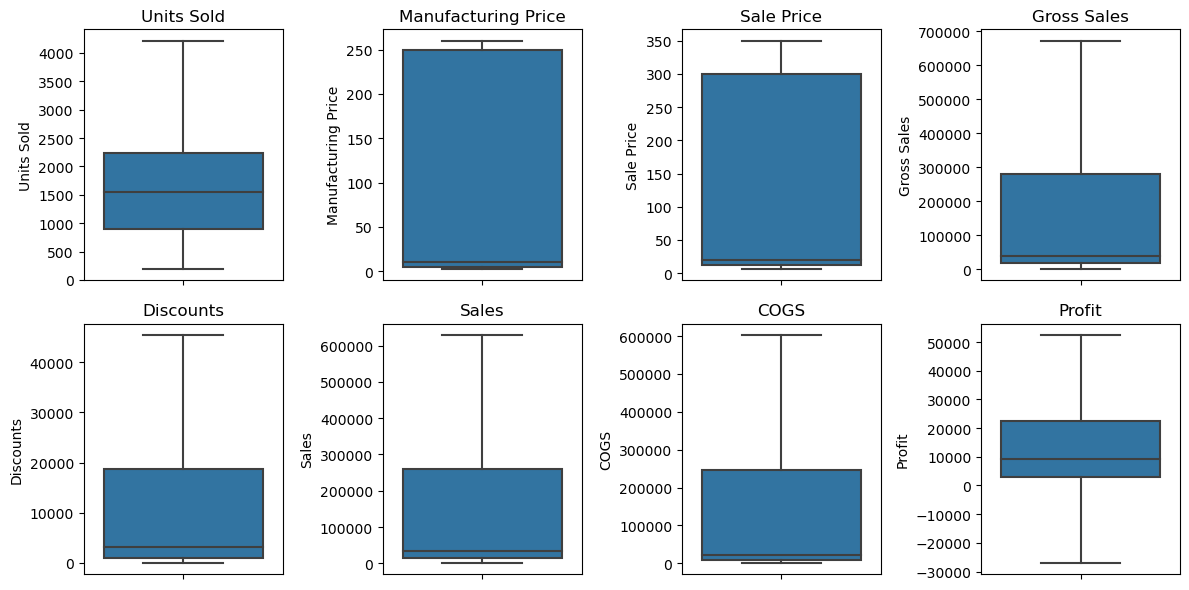

In [12]:
# Box Plots to visualize the distribution and detect outliers
plt.figure(figsize=(12, 6))
for i, column in enumerate(numeric_columns):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=company_df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

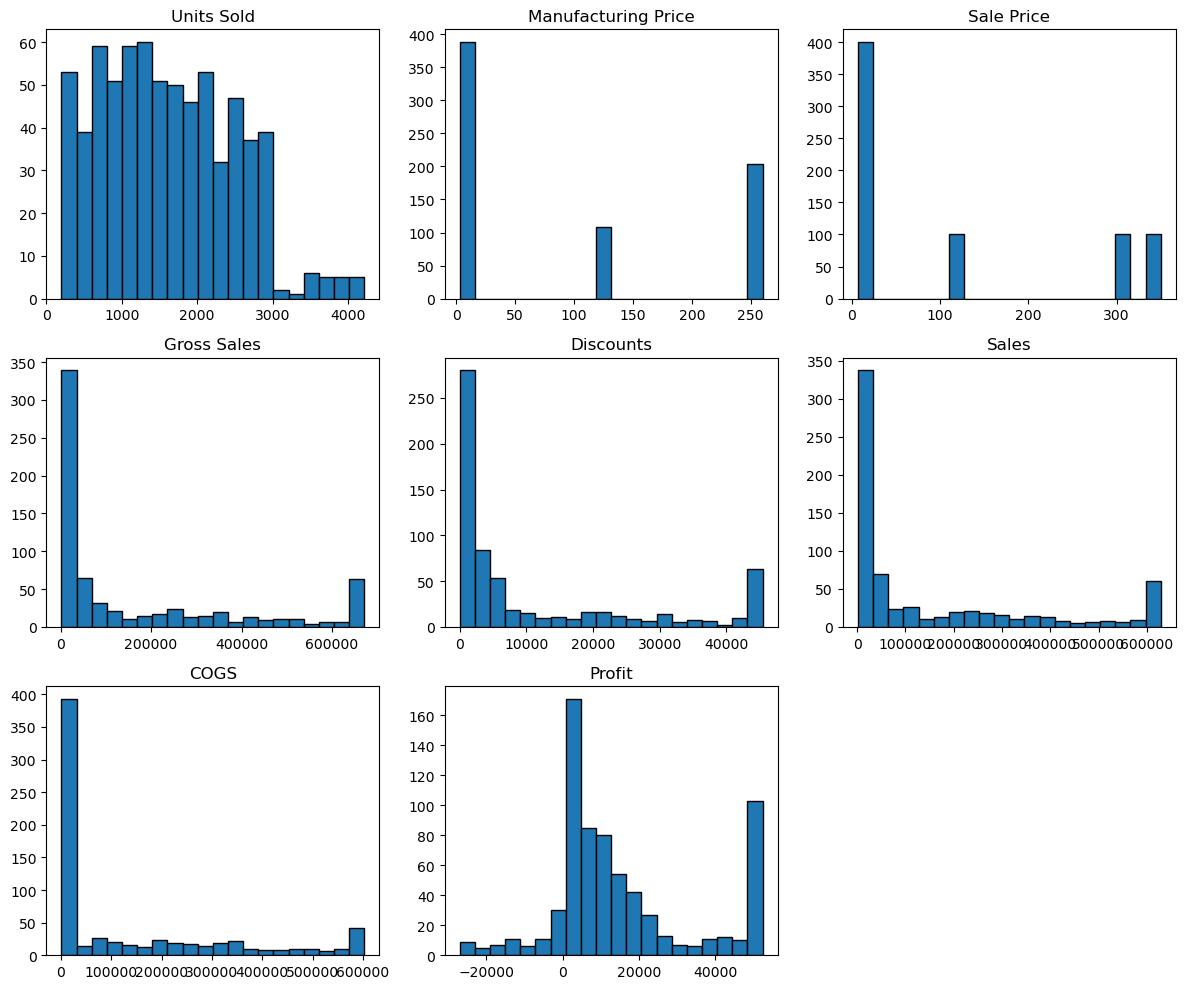

In [13]:
# Histograms for understanding the distribution of numeric variables
company_df[numeric_columns].hist(figsize=(12, 10), bins=20, grid=False, edgecolor='black')
plt.tight_layout()
plt.show()


## Sales Performance Analysis
Understanding sales performance across different segments is crucial for targeting marketing efforts and allocating resources effectively. The following visualization shows total sales by segment, helping to identify which segments contribute most to revenue.


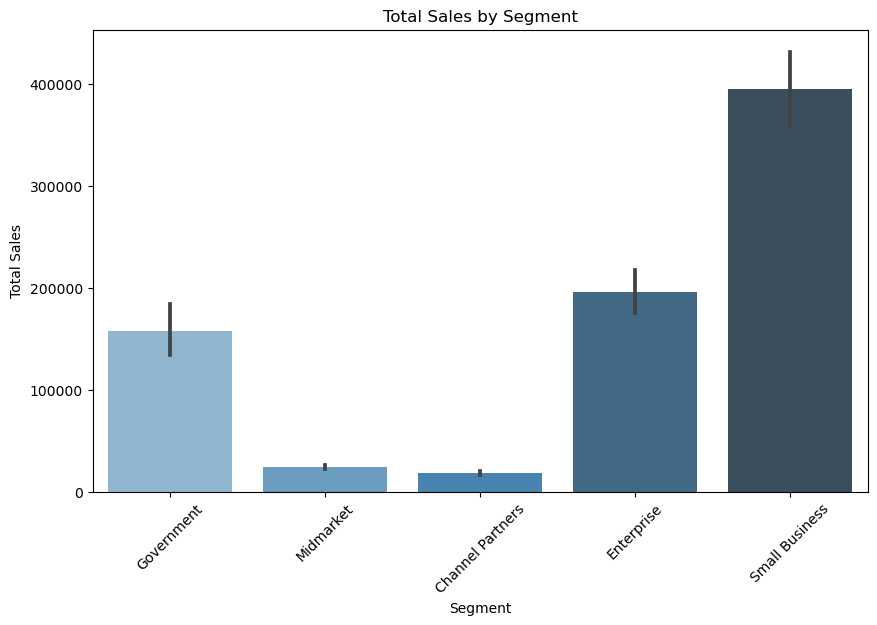

In [14]:
# Sales by Segment
plt.figure(figsize=(10, 6))
sns.barplot(x='Segment', y='Sales', data=company_df, palette='Blues_d')
plt.title('Total Sales by Segment')
plt.xticks(rotation=45)
plt.xlabel('Segment')
plt.ylabel('Total Sales')
plt.show()

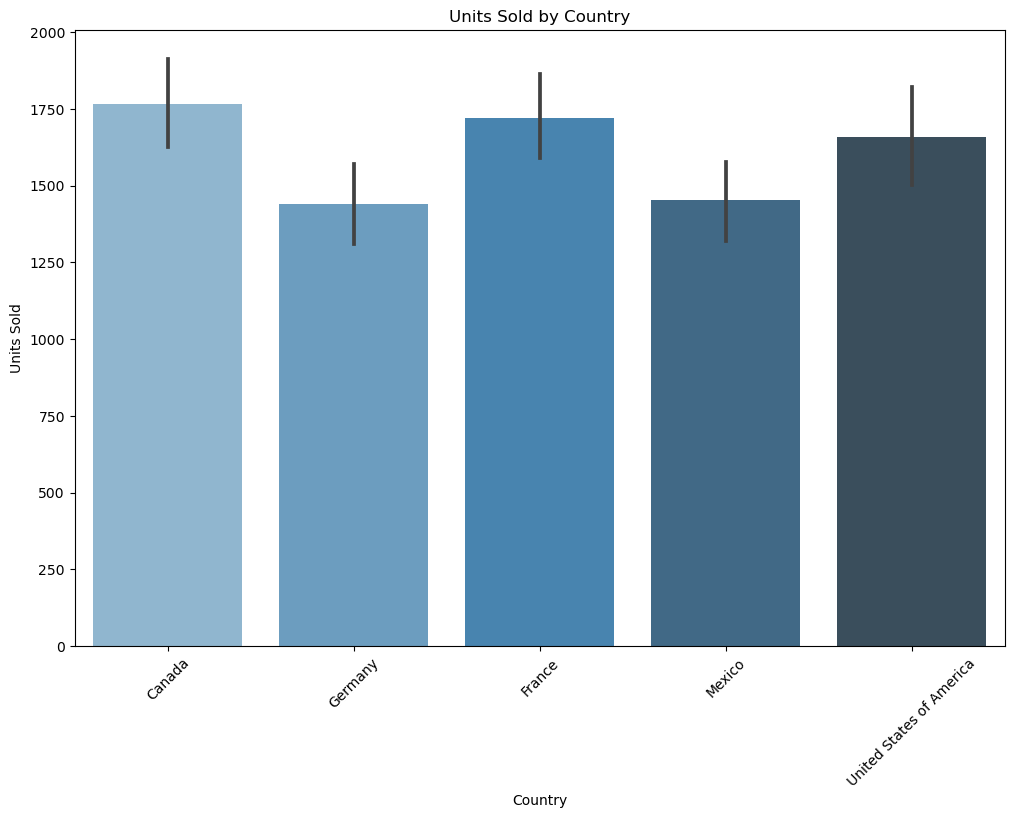

In [15]:
# Units Sold by Country
plt.figure(figsize=(12, 8))
sns.barplot(x='Country', y='Units Sold', data=company_df, palette='Blues_d')
plt.title('Units Sold by Country')
plt.xticks(rotation=45)
plt.xlabel('Country')
plt.ylabel('Units Sold')
plt.show()

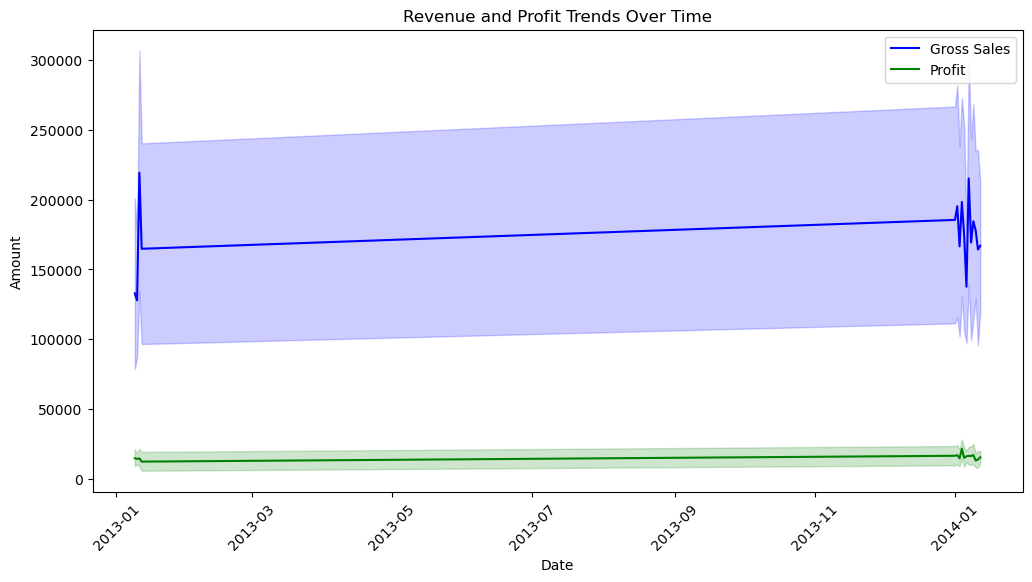

In [16]:
# Revenue and Profit Trends
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Gross Sales', data=company_df, label='Gross Sales', color='blue')
sns.lineplot(x='Date', y='Profit', data=company_df, label='Profit', color='green')
plt.title('Revenue and Profit Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.xticks(rotation=45)
plt.show()


## Sales Performance Analysis

### Summary of Findings:
- **Government Segment Dominance**: The Government segment is the largest contributor to total sales, indicating strong market penetration.
- **Potential Growth Areas**: The Small Business segment shows lower sales but may have untapped potential, suggesting a need for targeted strategies.

### Recommendations:
- **Focus Marketing on Government Segment**: Given its dominance, allocate more resources to reinforce this segment’s performance.
- **Explore Small Business Opportunities**: Develop specific marketing campaigns and product offerings tailored to the Small Business segment to drive growth.


## Pricing and Cost Analysis

Pricing and cost analysis are critical components of business strategy and financial management. Effective pricing strategies ensure that products are competitively priced while maximizing profit margins. By analyzing the relationship between manufacturing costs and sale prices, businesses can identify opportunities to optimize profitability and maintain a competitive edge in the market.

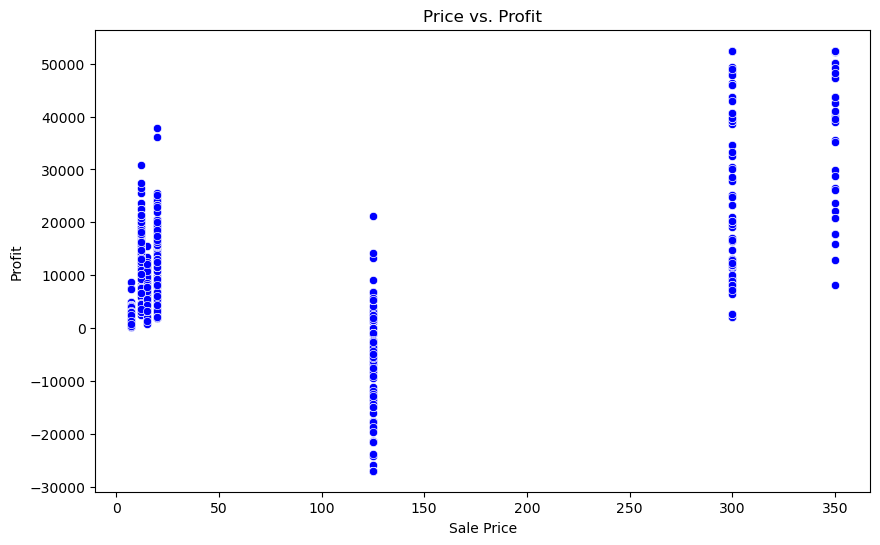

In [17]:
# Price vs. Profit
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Sale Price', y='Profit', data=company_df, color='blue')
plt.title('Price vs. Profit')
plt.xlabel('Sale Price')
plt.ylabel('Profit')
plt.show()


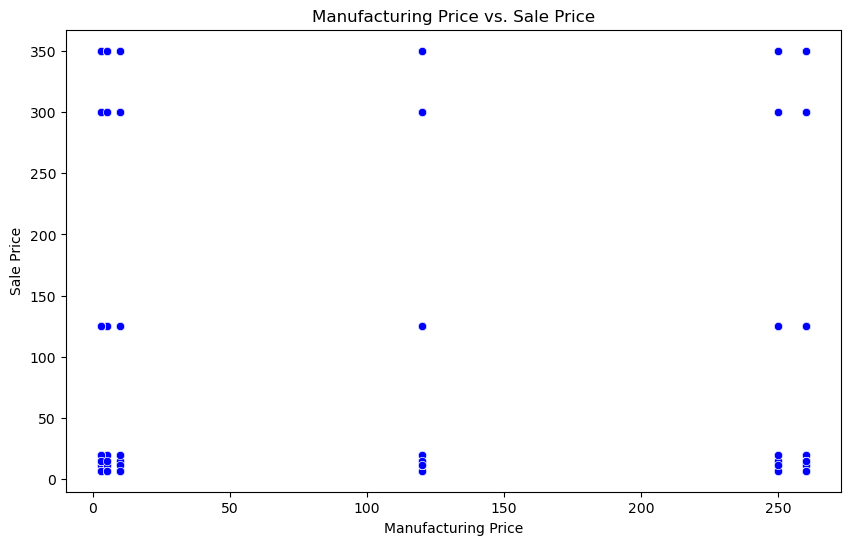

In [18]:
# Manufacturing Price vs. Sale Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Manufacturing Price', y='Sale Price', data=company_df, color='blue')
plt.title('Manufacturing Price vs. Sale Price')
plt.xlabel('Manufacturing Price')
plt.ylabel('Sale Price')
plt.show()


### Summary of Findings:
- **Price vs. Profit**: The scatter plot indicates a positive correlation between sale price and profit. Higher sale prices generally result in higher profits, as expected. However, there is a clustering of data points at specific price levels, suggesting standard pricing practices or product tiers.
- **Manufacturing Price vs. Sale Price**: The scatter plot shows that sale prices are typically higher than manufacturing prices, which is necessary for maintaining profitability. There is a broad range of sale prices even for similar manufacturing costs, indicating potential price variability based on market factors or product positioning.

### Recommendations:
- **Optimize Pricing Strategies**: Review the clustering of sale prices to understand why certain price points are favored. Consider if there’s room to adjust pricing strategies to maximize profit, particularly for products that are not hitting the higher profit margins.
- **Review Cost Management**: Although the sale prices generally exceed manufacturing costs, analyze the products with lower sale price margins to see if cost reductions or pricing adjustments could improve profitability.
- **Targeted Product Pricing**: Consider introducing differentiated pricing strategies for products with similar manufacturing costs but varying sale prices to ensure that each product’s price aligns with its perceived market value.
You can add this markdown directly under your "Pricing and Cost Analysis" section in your Jupyter

## Discount Impact Analysis

Discount impact analysis is crucial for understanding how discounting strategies affect sales, revenue, and profitability. Discounts can drive customer behavior, increase sales volume, and clear inventory, but they also directly impact profit margins. By analyzing the effectiveness of various discount bands, businesses can determine the optimal discount levels that maximize sales without eroding profitability.

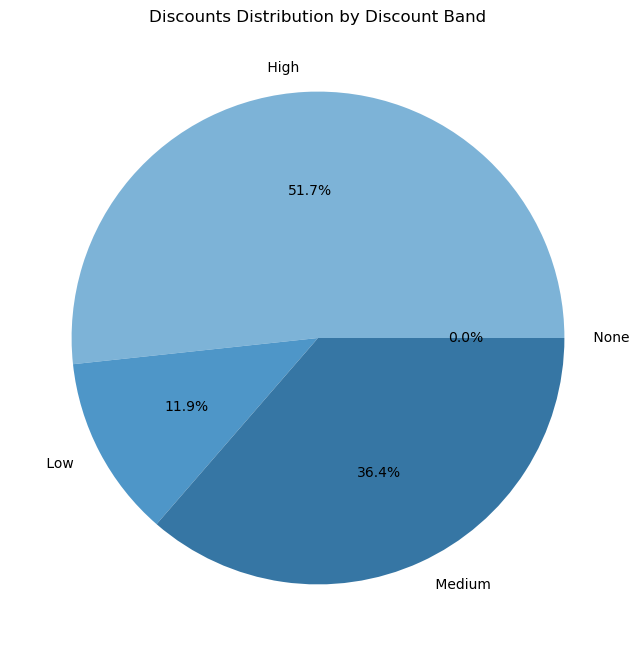

In [19]:
# Discounts vs. Sales
# Calculate total discounts by discount band
discounts_by_band = company_df.groupby('Discount Band')['Discounts'].sum()

plt.figure(figsize=(10, 8))
plt.pie(discounts_by_band, labels=discounts_by_band.index, autopct='%1.1f%%', colors=sns.color_palette('Blues_d', len(discounts_by_band)))
plt.title('Discounts Distribution by Discount Band')
plt.show()


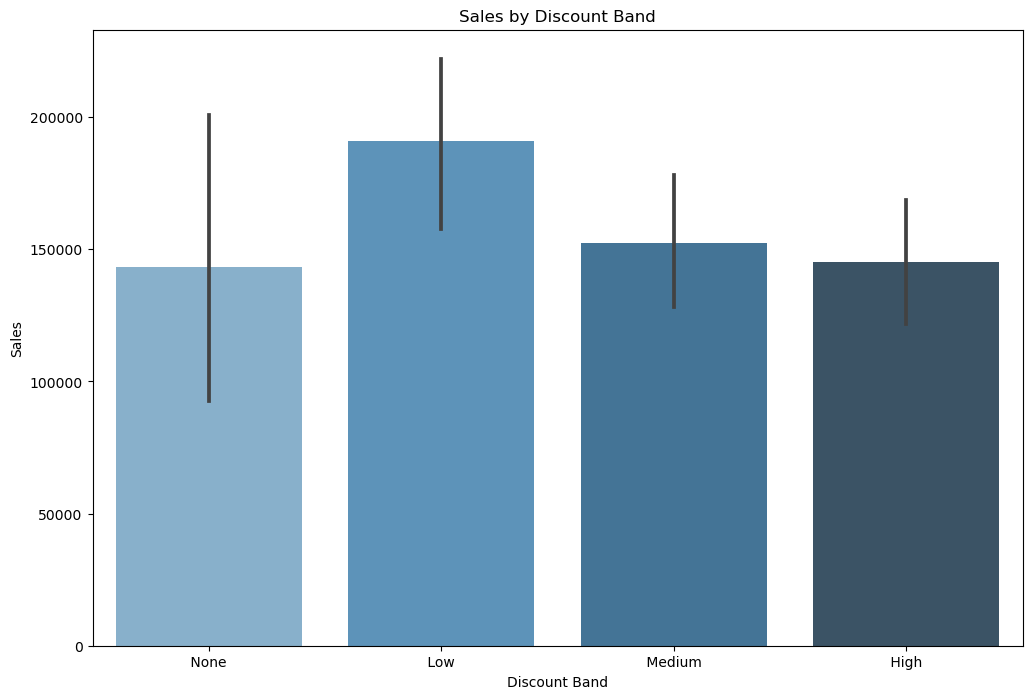

In [20]:
# Sales by Discount Band
plt.figure(figsize=(12, 8))
sns.barplot(x='Discount Band', y='Sales', data=company_df, palette='Blues_d')
plt.title('Sales by Discount Band')
plt.xlabel('Discount Band')
plt.ylabel('Sales')
plt.show()

### Summary of Findings:
- **Sales by Discount Band**: The bar plot indicates that discounts do have a significant impact on sales. However, the highest sales are observed in the "Low" and "None" discount bands, suggesting that significant discounts may not always be necessary to drive sales.
- **Discount Distribution by Band**: The pie chart shows that the majority of discounts fall into the "High" and "Medium" bands, indicating that substantial discounts are frequently applied. This raises questions about the overall pricing strategy and whether such high discounts are sustainable in the long term.

### Recommendations:
- **Reevaluate Discount Strategies**: Given that lower discount bands still drive significant sales, consider reducing the frequency or depth of high discounts. This could help in maintaining profitability without sacrificing sales volume.
- **Targeted Discount Campaigns**: Focus high discounts on specific products or market segments where they are most effective, rather than applying them broadly.
- **Monitor Discount Effectiveness**: Continuously analyze the impact of different discount bands on sales and profitability to refine discount strategies over time.


## Product Performance
Product performance analysis is crucial for understanding which products drive revenue and where opportunities exist for growth. It helps in making informed decisions about resource allocation, marketing focus, and product development, ultimately contributing to the company's profitability and market position.

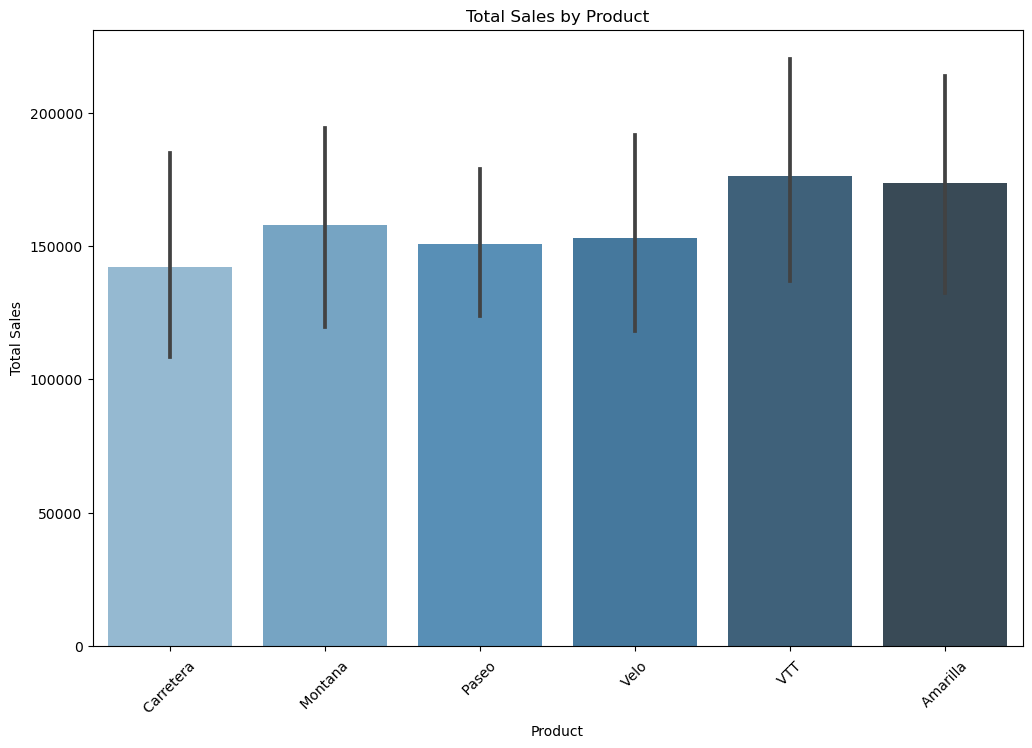

In [21]:
# Total Sales by Product
plt.figure(figsize=(12, 8))
sns.barplot(x='Product', y='Sales', data=company_df, palette='Blues_d')
plt.title('Total Sales by Product')
plt.xticks(rotation=45)
plt.xlabel('Product')
plt.ylabel('Total Sales')
plt.show()

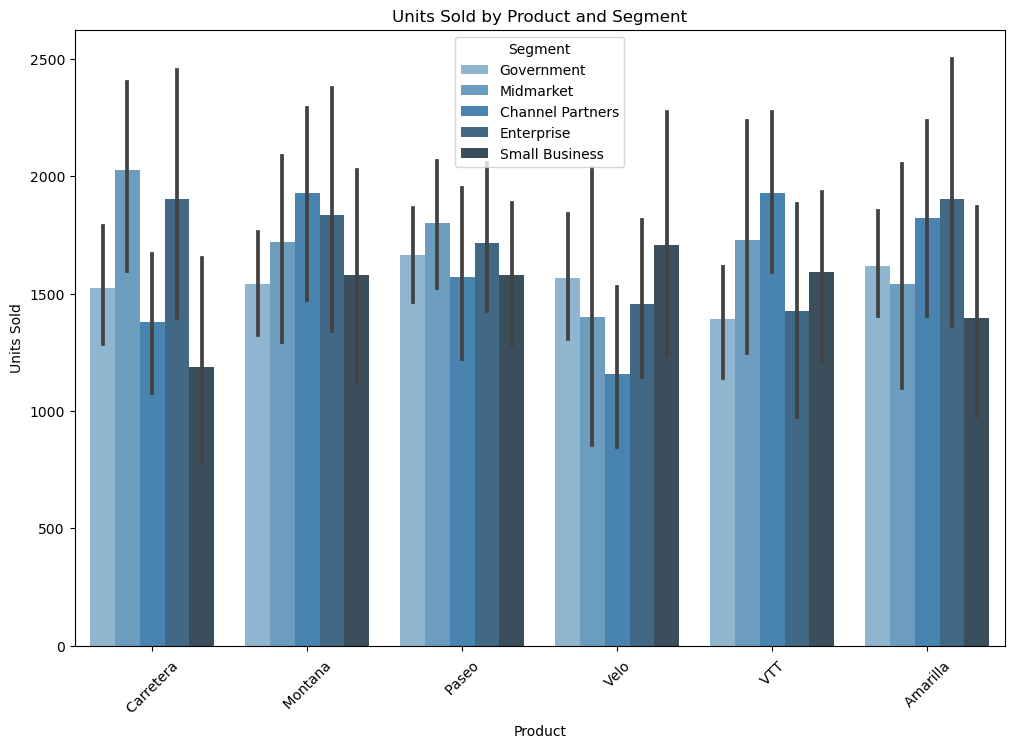

In [22]:
# Units Sold by Product and Segment
plt.figure(figsize=(12, 8))
sns.barplot(x='Product', y='Units Sold', hue='Segment', data=company_df, palette='Blues_d')
plt.title('Units Sold by Product and Segment')
plt.xticks(rotation=45)
plt.xlabel('Product')
plt.ylabel('Units Sold')
plt.legend(title='Segment')
plt.show()

## Product Performance

### Summary of Findings:
- **Total Sales by Product**: The bar plot shows the distribution of total sales across different products. The products appear to have a relatively even distribution of sales, with slight variations that suggest some products are slightly more popular or better-performing than others.
- **Units Sold by Product and Segment**: The stacked bar plot provides insights into the units sold for each product across different market segments. This detailed breakdown shows that certain products perform better in specific segments, indicating varying levels of market penetration and customer preference.

### Recommendations:
- **Focus on High-Performing Products**: Identify the products with the highest sales and consider focusing marketing and development efforts on these products to further boost their performance.
- **Segment-Specific Strategies**: Tailor marketing and sales strategies to specific segments where certain products are particularly successful. For instance, if a product performs well in the Government segment but not in Small Business, a targeted approach can be developed to increase penetration in the underperforming segments.
- **Evaluate Underperforming Products**: Products with consistently lower sales should be evaluated to determine if they need re-positioning, pricing adjustments, or even discontinuation if they do not align with market demand.


## Monthly and Yearly Trends
Analyzing monthly and yearly trends is crucial for understanding the timing of sales and profit fluctuations. This analysis allows businesses to anticipate seasonal changes, allocate resources more effectively, and make informed decisions to sustain long-term growth.


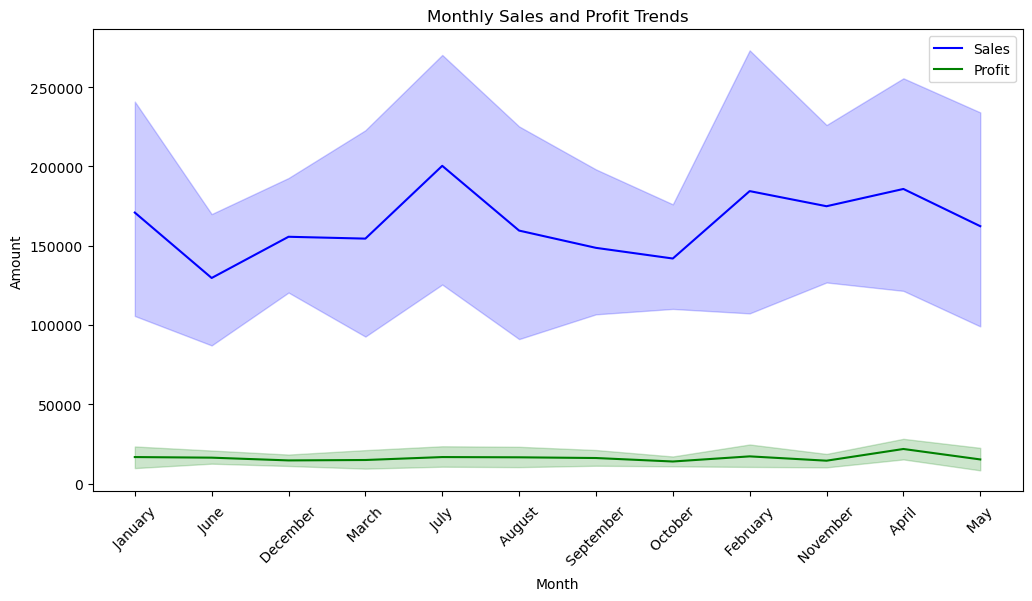

In [23]:
# Monthly Sales and Profit Trends
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month Name', y='Sales', data=company_df, label='Sales', color='blue')
sns.lineplot(x='Month Name', y='Profit', data=company_df, label='Profit', color='green')
plt.title('Monthly Sales and Profit Trends')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.legend()
plt.xticks(rotation=45)
plt.show()

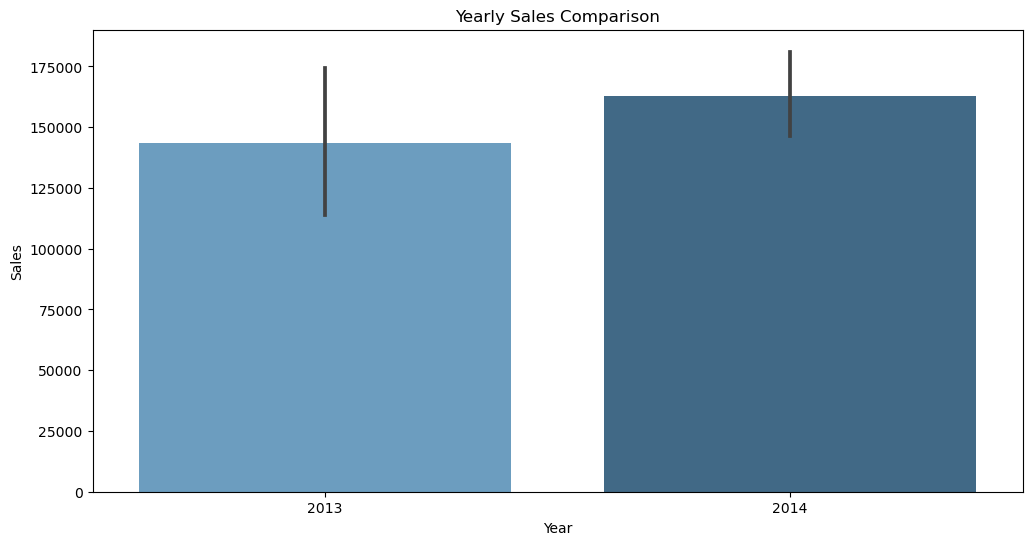

In [24]:
# Yearly Performance Comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Year', y='Sales', data=company_df, palette='Blues_d')
plt.title('Yearly Sales Comparison')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()


### Summary of Findings:
- **Monthly Sales and Profit Trends**: The line plot illustrates fluctuations in sales and profit throughout the year. The data suggests seasonal trends, with certain months consistently outperforming others in terms of sales and profit.
- **Yearly Sales Comparison**: The bar chart comparing sales between 2013 and 2014 shows an overall increase in sales year-over-year, indicating positive growth.

### Recommendations:
- **Leverage Seasonal Trends**: Identify the factors driving higher sales and profit during peak months and develop strategies to replicate this success during lower-performing months.
- **Sustain Yearly Growth**: Continue to analyze yearly trends to ensure sustained growth. Explore what contributed to the increased sales in 2014 and apply those insights to future strategies.

## Cost and Profitability Analysis
Cost and profitability analysis is crucial for identifying the factors that drive or hinder financial performance. By understanding the relationship between costs, sales, and profits, businesses can make informed decisions to optimize resource allocation, pricing strategies, and cost management practices, ultimately leading to sustained profitability.


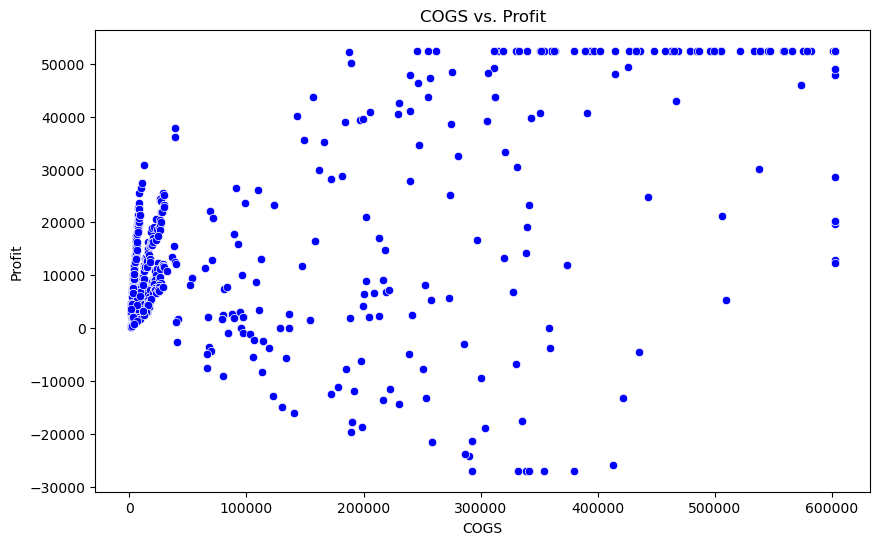

In [25]:
# COGS vs. Profit
plt.figure(figsize=(10, 6))
sns.scatterplot(x='COGS', y='Profit', data=company_df, color='blue')
plt.title('COGS vs. Profit')
plt.xlabel('COGS')
plt.ylabel('Profit')
plt.show()


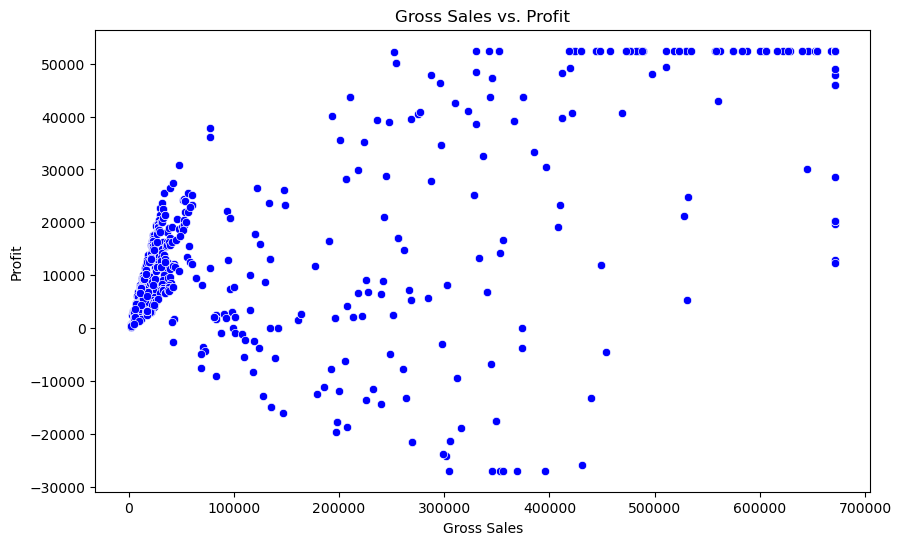

In [26]:
# Gross Sales vs. Profit
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Gross Sales', y='Profit', data=company_df, color='blue')
plt.title('Gross Sales vs. Profit')
plt.xlabel('Gross Sales')
plt.ylabel('Profit')
plt.show()

### Summary of Findings:
- **COGS vs. Profit**: The scatter plot indicates a wide range of COGS (Cost of Goods Sold) values relative to profit. There is a concentration of data points where low COGS correlates with varying profit levels, suggesting that while lower costs generally lead to higher profitability, other factors also influence profit.
- **Gross Sales vs. Profit**: The scatter plot shows a positive correlation between gross sales and profit. However, the spread of data points indicates that some high gross sales do not always correspond to equally high profits, pointing to potential inefficiencies or areas for cost management improvement.

### Recommendations:
- **Optimize Cost Management**: Focus on reducing COGS where possible to enhance profitability, particularly in areas where high costs do not translate into proportional profits.
- **Analyze High-Gross-Low-Profit Scenarios**: Investigate instances where high gross sales result in lower-than-expected profits. This could uncover inefficiencies in pricing, discounting, or cost management that can be addressed to improve overall profitability.

## Profitability Analysis

In [27]:
# Perform profitability analysis by segment and product
profitability_analysis = company_df.groupby(['Segment', 'Product']).agg({
    'Sales': 'sum',
    'Profit': 'sum'
}).reset_index()

# Calculate profitability as the ratio of Profit to Sales
profitability_analysis['Profitability (%)'] = (profitability_analysis['Profit'] / profitability_analysis['Sales']) * 100

profitability_analysis

,Segment,Product,Sales,Profit,Profitability (%)
0,Channel Partners,Amarilla,317643.00,230068.50,72.429898
1,Channel Partners,Carretera,282838.68,208405.68,73.683585
2,Channel Partners,Montana,261844.56,192457.56,73.500691
3,Channel Partners,Paseo,454514.40,331838.40,73.009436
4,Channel Partners,VTT,300828.96,219765.96,73.053459
5,Channel Partners,Velo,182924.04,134267.04,73.400434
6,Enterprise,Amarilla,2643607.50,-85864.95,-3.248022
7,Enterprise,Carretera,3203708.13,-203359.32,-6.347623
8,Enterprise,Montana,2614843.75,-31096.25,-1.189220
9,Enterprise,Paseo,5267860.00,-81740.00,-1.551674


In [28]:
import pandas as pd

# Perform profitability analysis by country and segment
profitability_by_country_segment = company_df.groupby(['Country', 'Segment']).agg({
    'Sales': 'sum',
    'Profit': 'sum'
}).reset_index()

# Calculate profitability as the ratio of Profit to Sales
profitability_by_country_segment['Profitability (%)'] = (profitability_by_country_segment['Profit'] / profitability_by_country_segment['Sales']) * 100

profitability_by_country_segment

,Country,Segment,Sales,Profit,Profitability (%)
0,Canada,Channel Partners,491164.14,358978.14,73.087205
1,Canada,Enterprise,3967491.25,-107869.35,-2.718830
2,Canada,Government,9551859.52,1263603.36,13.228873
3,Canada,Midmarket,510213.98,132488.98,25.967336
4,Canada,Small Business,8303294.25,666731.48,8.029722
5,France,Channel Partners,372090.36,271581.36,72.988013
6,France,Enterprise,3890890.63,-95749.37,-2.460860
7,France,Government,10937191.72,1346207.99,12.308534
8,France,Midmarket,593802.08,164542.08,27.709920
9,France,Small Business,7271147.25,606653.24,8.343295


In [42]:
# Perform profitability analysis by country and product
profitability_by_country_product = company_df.groupby(['Country', 'Product']).agg({
    'Sales': 'sum',
    'Profit': 'sum'
}).reset_index()

# Calculate profitability as the ratio of Profit to Sales
profitability_by_country_product['Profitability (%)'] = (profitability_by_country_product['Profit'] / profitability_by_country_product['Sales']) * 100

profitability_by_country_product

,Country,Product,Sales,Profit,Profitability (%)
0,Canada,Amarilla,3778967.63,403193.18,10.669400
1,Canada,Carretera,2260770.09,251835.40,11.139364
2,Canada,Montana,2260962.53,247974.15,10.967636
3,Canada,Paseo,7062694.49,788888.60,11.169796
4,Canada,VTT,4710604.06,372745.76,7.912908
5,Canada,Velo,2750024.34,249295.52,9.065211
6,France,Amarilla,3318867.13,246083.81,7.414693
7,France,Carretera,3305416.15,216891.58,6.561703
8,France,Montana,3527382.37,357490.30,10.134719
9,France,Paseo,5400207.56,556218.86,10.299953


### Summary of Findings:
- **Channel Partners** segment is highly profitable, with profitability rates above **70%** across most products.
- **Enterprise** segment operates at a loss, with negative profitability ranging from **-1% to -6%** in multiple countries.
- **Small Business** segment shows low profitability, typically between **6% and 9%**, with some products like **Velo** underperforming.

### Recommendations:
- **Address losses in Enterprise**: Investigate cost structure and pricing in the **Enterprise** segment to improve profitability.
- **Optimize Small Business**: Focus on pricing or operational improvements for low-performing products like **Velo** and **Amarilla**.
- **Invest in High-Performers**: Prioritize investment in high-performing products like **Montana** in profitable regions like **Mexico**.
